In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

pd.set_option('display.max_colwidth', None)

df = pd.read_csv('home_data_clean.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   zip         343 non-null    int64  
 1   city        343 non-null    object 
 2   price       343 non-null    float64
 3   baths       343 non-null    float64
 4   beds        343 non-null    float64
 5   home_sqft   343 non-null    float64
 6   type        343 non-null    object 
 7   url         343 non-null    object 
 8   year_built  343 non-null    float64
 9   lot_sqft    343 non-null    float64
dtypes: float64(6), int64(1), object(3)
memory usage: 26.9+ KB


## 1. Price Summary and Distribution

In [2]:
df.describe()['price']

count    3.430000e+02
mean     1.006613e+06
std      9.108668e+05
min      7.500000e+04
25%      6.059475e+05
50%      7.800000e+05
75%      1.162500e+06
max      9.495000e+06
Name: price, dtype: float64

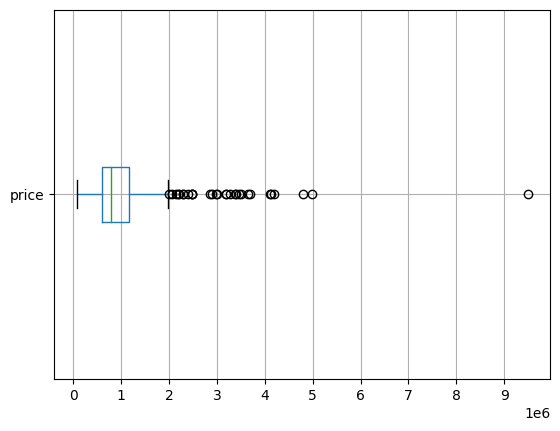

In [3]:
df.boxplot(column='price', vert=False)
plt.xticks(ticks=np.arange(0, 10000000, 1000000))
plt.grid(visible=True, which='both')
plt.show()

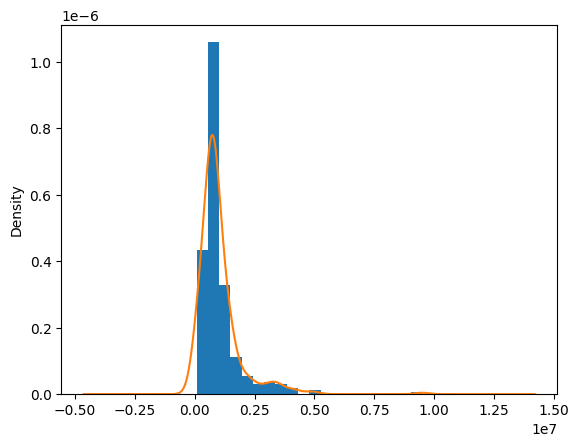

In [4]:
fig, ax = plt.subplots()
df['price'].plot.hist(bins=20, density=True)
df['price'].plot.density(ax=ax)
plt.show()

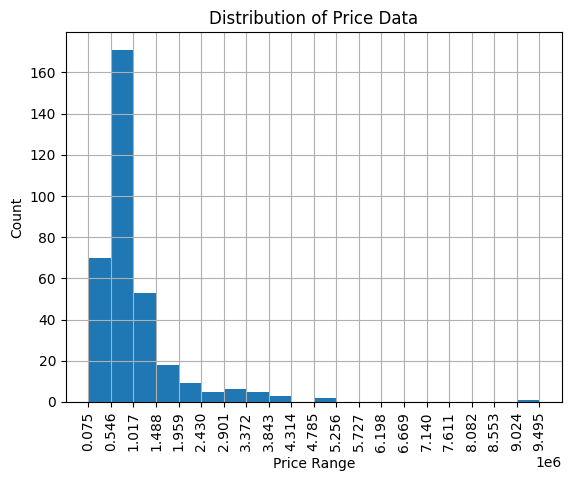

In [5]:
df.hist(column='price', bins=20, xrot=90)
plt.xticks(ticks=np.linspace(df['price'].min(), df['price'].max(), 21))
plt.xlabel('Price Range')
plt.ylabel('Count')
plt.title('Distribution of Price Data')
plt.show()

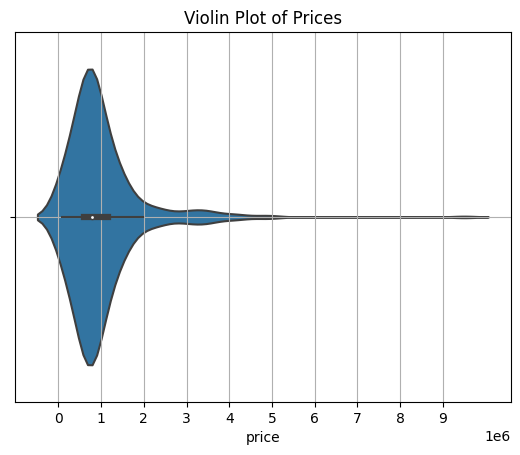

In [6]:
sns.violinplot(x=df['price'])
plt.grid(visible=True)
plt.xticks(ticks=np.arange(0, 10000000, 1000000))
plt.title('Violin Plot of Prices')
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
prices_stdrd = scale.fit_transform(df['price'].values.reshape(-1, 1))
prices_stdrd = prices_stdrd.flatten()

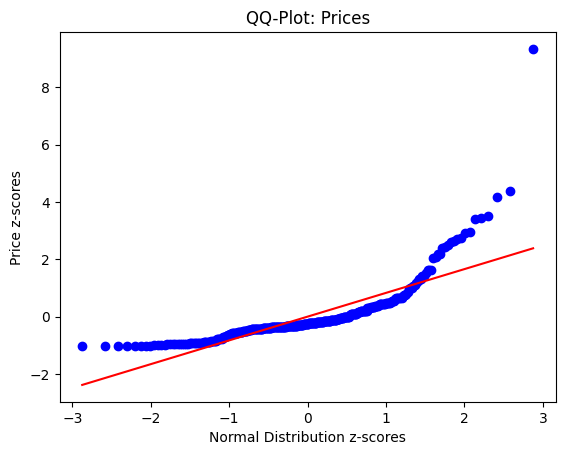

In [8]:
fig, ax = plt.subplots()
stats.probplot(prices_stdrd, plot=ax)
plt.xlabel('Normal Distribution z-scores')
plt.ylabel('Price z-scores')
plt.title('QQ-Plot: Prices')
plt.show()

- The prices of the majority of homes fall within the range of about 500,000 to 1 million.
- The data is heavily skewed upward, containing a large number of potential outliers.

## 2. Correlations

To find correlations between the predictor variables and price.

In [9]:
df_dummies = pd.get_dummies(df, columns=['zip', 'city', 'type'])
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 343 entries, 0 to 342
Data columns (total 37 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price               343 non-null    float64
 1   baths               343 non-null    float64
 2   beds                343 non-null    float64
 3   home_sqft           343 non-null    float64
 4   url                 343 non-null    object 
 5   year_built          343 non-null    float64
 6   lot_sqft            343 non-null    float64
 7   zip_91702           343 non-null    bool   
 8   zip_91706           343 non-null    bool   
 9   zip_91711           343 non-null    bool   
 10  zip_91722           343 non-null    bool   
 11  zip_91723           343 non-null    bool   
 12  zip_91724           343 non-null    bool   
 13  zip_91740           343 non-null    bool   
 14  zip_91741           343 non-null    bool   
 15  zip_91744           343 non-null    bool   
 16  zip_9175

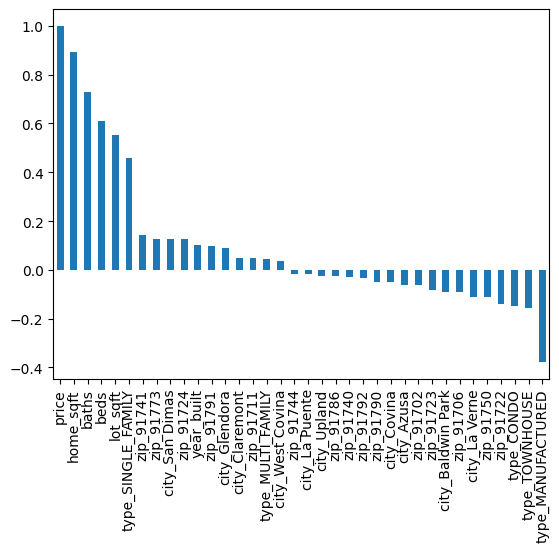

In [10]:
price_corr = df_dummies.corr(numeric_only=True)['price'].sort_values(ascending=False)
price_corr.plot.bar()
plt.show()

- The features that are most positively correlated with price are square footage, number of bathrooms and bedrooms, and single-family homes.
- The feature most negatively correlated with price is manufactured homes.

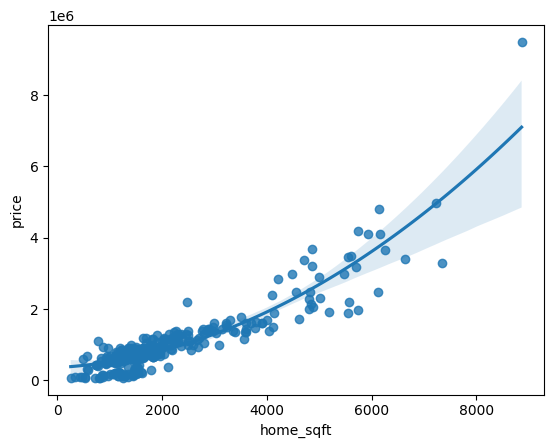

In [11]:
sns.regplot(data=df, x='home_sqft', y='price', order=2)
plt.show()

The relationship between price and home_sqft appears to be best modeled by a quadratic function.

## 4. Price by Home Type

Determine how a home's type affects its price.

Since price is highly correlated with home_sqft, we will combine them into one metric, price_per_sqft.

In [ ]:
df['price_per_sqft'] = df['price']/df['home_sqft']

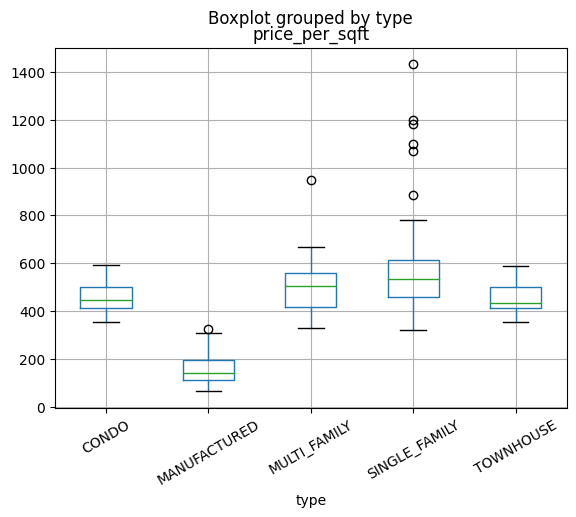

In [12]:
df.boxplot(column='price_per_sqft', by='type')
plt.xticks(rotation=30)
plt.show()

- The least expensive type of home is manufactured.
- The most expensive types are single-family and multi-family.
- Single family homes have the greatest variability and number of outliers, and it is skewed upward.

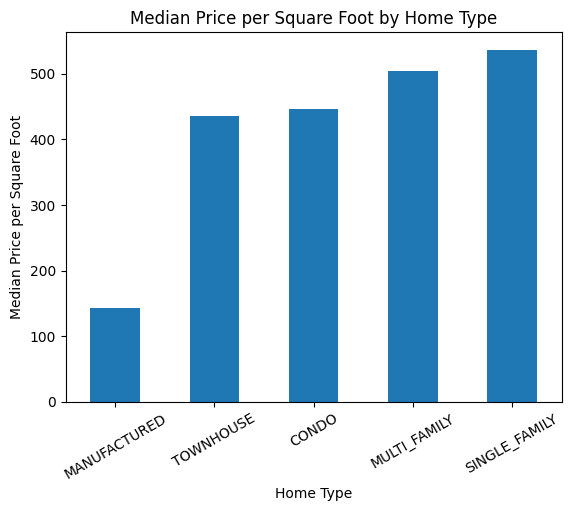

In [13]:
df.groupby('type')['price_per_sqft'].median().sort_values().plot.bar()
plt.xticks(rotation=30)
plt.xlabel('Home Type')
plt.ylabel('Median Price per Square Foot')
plt.title('Median Price per Square Foot by Home Type')
plt.show()

By factoring in square footage of the home, the following becomes apparent:
-  Manufactured homes are far less expensive than other home types.
- Townhouses and Condos are comparable in price.
- Single family homes are the most expensive (though this does not account for lot square footage).

#### ANOVA: Price by Home Type

In [35]:
obs_variance = df.groupby('type')['price_per_sqft'].mean().var()
print('Variance:', obs_variance)

def perm_test(df):
    df = df.copy()
    df['price'] = np.random.permutation(df['price_per_sqft'].values)
    return df.groupby('type')['price_per_sqft'].mean().var()

perm_variance = [perm_test(df) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > obs_variance for var in perm_variance]))

Variance: 23745.17223441993
Pr(Prob) 0.0


The differences in price_per_sqft by home type are statistically significant, the p-value being very near 0.

Now, let us perform a pairwise TukeyHSD to determine which home types are different from each other.

#### Pairwise TukeyHSD (price, type)

In [34]:
tukey = pairwise_tukeyhsd(endog=df['price_per_sqft'], groups=df['type'], alpha=0.05)
print(tukey)

          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
    group1        group2     meandiff p-adj    lower     upper   reject
-----------------------------------------------------------------------
        CONDO  MANUFACTURED -293.4608    0.0 -362.3274 -224.5942   True
        CONDO  MULTI_FAMILY   62.1639 0.5014  -44.7088  169.0365  False
        CONDO SINGLE_FAMILY   94.0763 0.0001   37.2136   150.939   True
        CONDO     TOWNHOUSE   -1.6301    1.0   -71.423   68.1628  False
 MANUFACTURED  MULTI_FAMILY  355.6247    0.0  251.7525  459.4968   True
 MANUFACTURED SINGLE_FAMILY  387.5371    0.0  336.5369  438.5373   True
 MANUFACTURED     TOWNHOUSE  291.8307    0.0  226.7254  356.9361   True
 MULTI_FAMILY SINGLE_FAMILY   31.9124 0.8935  -64.4213  128.2462  False
 MULTI_FAMILY     TOWNHOUSE  -63.7939 0.4512 -168.2825   40.6947  False
SINGLE_FAMILY     TOWNHOUSE  -95.7063    0.0 -147.9506   -43.462   True
----------------------------------------------------------------

- The differences in price_per_sqft between manufactured homes and every other home types are statistically significant. Manufactured homes are priced lower because they are manufactured homes.
- The difference in price_per_sqft between condos and townhouses is not statistically signficant.
- The difference in price_per_sqft between single-family homes and multi-family homes is not statistically significant.
- The differences in price_per_sqft between single-family homes and townhouses/condos is statistically significant. Single-family homes are more expensive than condos and townhouses.

## 3. Price by Location

Determine how a home's location affects its price.

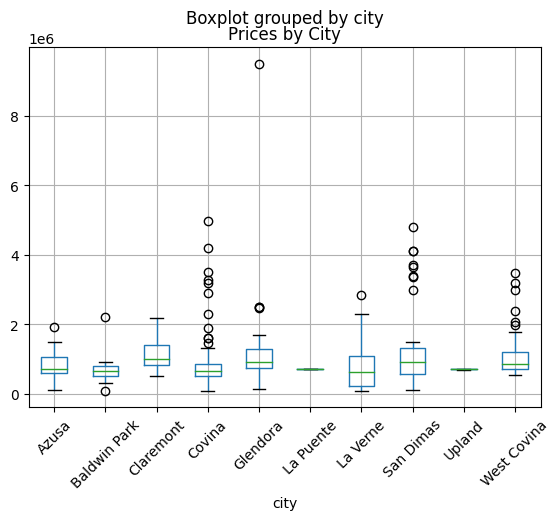

In [15]:
df.boxplot(column='price', by='city')
plt.title('Prices by City')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Drop greatest outlier
df.drop(df[df['price']==df['price'].max()].index, inplace=True)

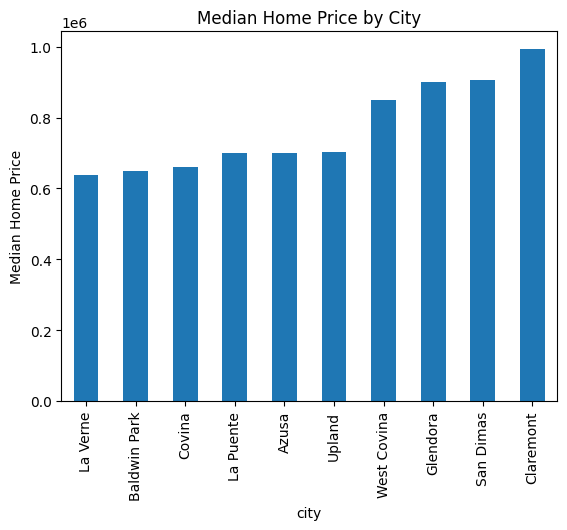

In [17]:
df.groupby('city')['price'].median().sort_values().plot.bar()
plt.title('Median Home Price by City')
plt.ylabel('Median Home Price')
plt.show()

However, since there may be an imbalance in home type ratios across cities (and we already know that home type is highly correlated with price), we will analyze the differences in price by both city and home type.

In [18]:
table = df.pivot_table(index=['type'], columns=['city'], values='price', aggfunc=np.median)
table.drop(columns=['La Puente', 'Upland'], inplace=True)
table

city,Azusa,Baldwin Park,Claremont,Covina,Glendora,La Verne,San Dimas,West Covina
type,,,,,,,,
CONDO,567450.0,377500.0,879990.0,624700.0,655000.0,698990.0,580000.0,739850.0
MANUFACTURED,130000.0,79979.0,NaN,94500.0,179900.0,215000.0,175000.0,NaN
MULTI_FAMILY,1440000.0,900000.0,NaN,1124900.0,1600000.0,868000.0,NaN,1344419.0
SINGLE_FAMILY,823000.0,686500.0,1350000.0,1024400.0,1024999.5,1162500.0,1150000.0,914995.0
TOWNHOUSE,704950.0,480000.0,775000.0,618400.0,752000.0,654990.0,592000.0,679990.0


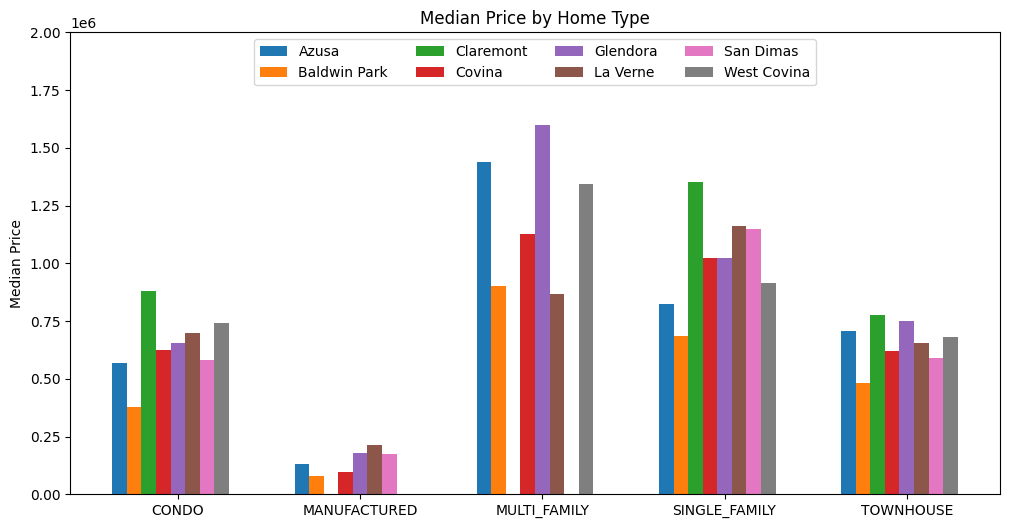

In [19]:
x = np.arange(len(table.index))
width = 0.08
multiplier = 0

fig, ax = plt.subplots(figsize=(12, 6))
for city, price in table.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, price, width, label=city)
    #ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Median Price').
ax.set_title('Median Price by Home Type')
ax.set_xticks(x + 4*width, table.index)
ax.legend(loc='upper center', ncols=4)
ax.set_ylim(0, 2000000)

plt.show()

In [20]:
table.mean().sort_values()

city
Baldwin Park    5.047958e+05
San Dimas       6.242500e+05
Covina          6.973800e+05
La Verne        7.198960e+05
Azusa           7.330800e+05
Glendora        8.423799e+05
West Covina     9.198135e+05
Claremont       1.001663e+06
dtype: float64

#### ANOVA: Price by City

In [21]:
obs_variance = df.groupby('city')['price'].mean().var()
print('Variance:', obs_variance)

def perm_test(df):
    df = df.copy()
    df['price'] = np.random.permutation(df['price'].values)
    return df.groupby('city')['price'].mean().var()

perm_variance = [perm_test(df) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > obs_variance for var in perm_variance]))

Variance: 49593432039.01408
Pr(Prob) 0.477


#### 2-Way ANOVA (price ~ city + type)

In [23]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = smf.ols('price ~ city + type + city:type', data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table

/home/joseph/Data_Science/HousePrices/venv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 9, but rank is 7
  warnings.warn('covariance of constraints does not have full '
/home/joseph/Data_Science/HousePrices/venv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 3
  warnings.warn('covariance of constraints does not have full '
/home/joseph/Data_Science/HousePrices/venv/lib/python3.11/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 36, but rank is 25
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
city,1.187250e+13,9.0,3.150445,3.141369e-03
type,7.906005e+13,4.0,47.202953,4.511641e-25
city:type,1.048511e+13,36.0,0.695573,8.611918e-01
Residual,1.272921e+14,304.0,NaN,NaN


- The difference in means by both city and home type is statistically significant given an alpha value of 0.05 

#### Pairwise Tukey (price, city)

In [24]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [25]:
df_sf = df[df['type']=='SINGLE_FAMILY']
tukey = pairwise_tukeyhsd(endog=df_sf['price'], groups=df_sf['city'], alpha=0.05)
print(tukey)

              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
   group1       group2      meandiff   p-adj      lower        upper     reject
-------------------------------------------------------------------------------
       Azusa Baldwin Park -121962.8141    1.0  -1162919.825  918994.1968  False
       Azusa    Claremont  415948.8745 0.8985  -519998.8697 1351896.6187  False
       Azusa       Covina  718880.2308 0.2134  -164401.0828 1602161.5444  False
       Azusa     Glendora  244543.3281 0.9925  -603392.3002 1092478.9563  False
       Azusa    La Puente -230445.2308    1.0 -2928914.2171 2468023.7555  False
       Azusa     La Verne  431851.9915 0.8839  -514598.7321  1378302.715  False
       Azusa    San Dimas   883537.584 0.0472     5725.5572 1761349.6109   True
       Azusa  West Covina  296726.0549 0.9691   -528570.653 1122022.7629  False
Baldwin Park    Claremont  537911.6886 0.7075   -420911.465 1496734.8421  False
Baldwin Park       Covina  840843.0449 0

- Claremont homes have the greatest median price for every home type it has homes for.
- Baldwin Park homes have the lowest median price for every home type (excluding multi-family homes).

## 5. Year Built

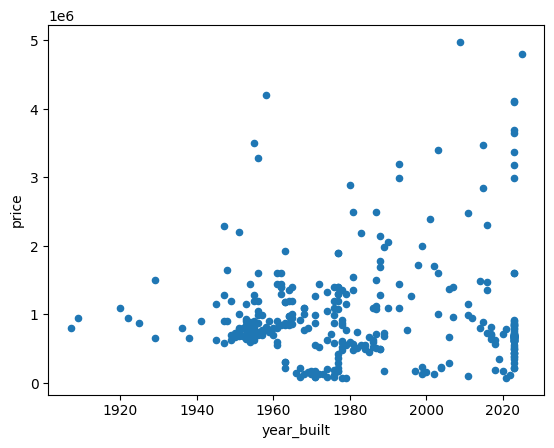

In [27]:
df.plot.scatter(x='year_built', y='price')
plt.show()

In [28]:
year_bins = pd.cut(df['year_built'], bins=[1900, 1960, 2000, 2023], labels=['pre-1960', '1960-2000', '2000-present'])
year_bins.name = 'year_bin'
df2 = pd.concat([df, year_bins], axis=1)

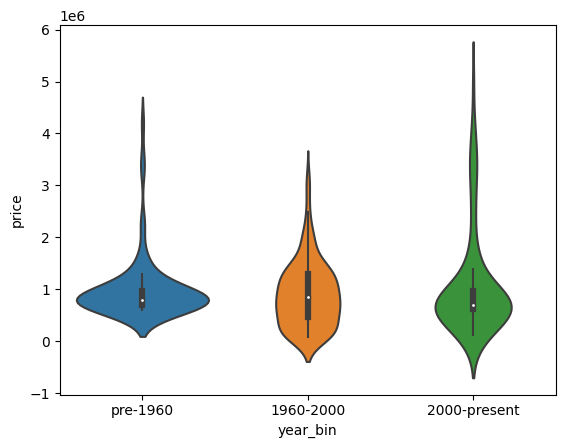

In [29]:
sns.violinplot(data=df2, x='year_bin', y='price')
plt.show()

There is no simple relationship between the year a home was built and it's price.

However, ignoring outliers, the variability in price appears to be lowest in homes built before 1960 and greatest in homes built 1960-2000.